In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from numpy import sin, cos, arccos

# map
import folium
from branca.element import Figure

# Load data, parse dates, convert duration to minutes
ddf = (pd.read_csv('edinburgh_bikes.csv').drop(['Unnamed: 0', 'index'], axis=1))

ddf[['started_at', 'ended_at']] = (
    ddf[['started_at', 'ended_at']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S'))

ddf['duration'] = ddf['duration'].apply(lambda x: x/60)  # minutes
ddf.rename(columns={'duration': 'duration_min'}, inplace=True)

## Popis datového souboru
- 438259 záznamů výpůjček kol 
- časové rozmezí 15.9.2018 až 30.6.2021
- záznamy obsahují datum a čas výpůjčky a vrácení kola, dobu trvání výpůjčky v sekundách, identifikaci odjezdové a příjezdové stanice (číslo, název, popis, souřadnice)
- data jsou kompletní (chybí pouze slovní popis některých stanic)

### První a poslední záznam

In [2]:
ddf.sort_values('started_at').iloc[[0,-1]]

,started_at,ended_at,duration_min,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05,2018-09-15 09:11:48,19.7,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
438258,2021-06-30 23:58:33,2021-07-01 00:07:15,8.7,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,1769,Brunswick Place,Corner of Elm Row/Brunswick Street,55.960852,-3.180986


## Délka trvání jedné výpůjčky
- nejvíce výpůjček trvá 5-10 minut
- polovina výpůjček trvá do 20 minut (medián 19.4 min)
- 99.9 % všech výpůjček trvá do 6,5 hodiny
- hranice odlehlých hodnot je diskutabilní, z povahy služby půjčování kol lze předpokládat, že budou vrácena ve stejný den, a proto výpůjčky delší než např. 12 hodin lze považovat za odlehlé (171 záznamů)
- graf znázorňuje četnost výpůjček podle délky jízdy po 5 minutách

### Popisná statistika

In [3]:
duration_df = ddf.loc[:, ['duration_min']]
(round(duration_df.describe(percentiles=[.05, .25, .50, .75, .95, .999]), 1)).T

,count,mean,std,min,5%,25%,50%,75%,95%,99.9%,max
duration_min,438259.0,32.5,94.3,1.0,4.6,10.4,19.4,42.2,90.2,392.7,39389.1


In [4]:
(print('Duration > 12 hrs, count: {}'
       .format(duration_df.query('duration_min > 720').count()[0])))

Duration > 12 hrs, count: 171


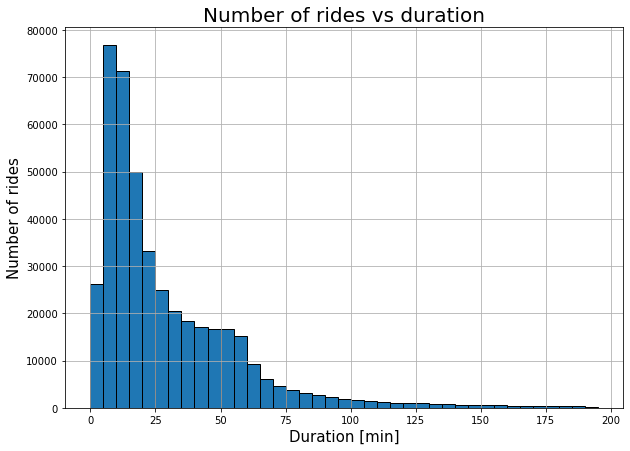

In [5]:
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(duration_df, bins=list(range(0, 200, 5)), edgecolor='black')
ax.set_title('Number of rides vs duration', fontsize=20)
ax.set_xlabel('Duration [min]', fontsize=15)
ax.set_ylabel('Number of rides', fontsize=15)
ax.grid()

## Aktivní a neaktivní stanice

- celkový počet stanic 200
- pro každou stanici byl vypočítán celkový počet odjezdů a příjezdů kol za den
- hranice pro neaktivní stanice byla stanovena na 1 odjezd a 1 příjezd týdně

**Výsledky:**
- rozsah aktivity je 0-32 odjezdů/příjezdů za den
- polovina stanic má aktivitu 2 odjezdy/příjezdy za den
- počet neaktivních stanic je 42 (21 % celku)
- provoz na aktivních stanicích je znáznorněn na histogramu

In [6]:
# List of all stations - ID + name
s1 = (ddf[['start_station_id', 'start_station_name']]
      .rename(columns={'start_station_id': 'station_ID',
                       'start_station_name': 'station_name'}))
s2 = (ddf[['end_station_id', 'end_station_name']]
      .rename(columns={'end_station_id': 'station_ID',
                       'end_station_name': 'station_name'}))
stations_df = (s1.append(s2)
               .drop_duplicates(subset='station_ID')
               .set_index('station_ID')
               .sort_index())

### Tabulka odjezdů a příjezdů za den
- začátek a konec tabulky

In [7]:
# Number of departures, arrivals and their sum for each station
activity_df = (stations_df
               .assign(departures = ddf.groupby('start_station_id')
                       .count()[['started_at']])
               .assign(arrivals = ddf.groupby('end_station_id')
                       .count()[['ended_at']])
               .fillna(0)
               .astype({'departures': int, 'arrivals': int}))
activity_df['total'] = (activity_df['departures']
                              + activity_df['arrivals'])

# Days between last and first record
interval_days = ((ddf.sort_values('started_at').iloc[-1,1] - ddf.sort_values('started_at')
                  .iloc[0,0]).days)
# Daily activity
activity_df[['departures', 'arrivals', 'total']] = (round(
    activity_df[['departures', 'arrivals', 'total']]
                     .transform(lambda x: x/interval_days), 1))
activity_df = (activity_df
               .sort_values('total')
               .reset_index()
               .set_index('station_name'))
 
activity_df.iloc[[0,1,-2,-1]]

,station_ID,departures,arrivals,total
station_name,,,,
Crescent House,1746,0.0,0.0,0.0
Holyrood Park - Woman's Tour Of Scotland (Event 11/08/19),1032,0.0,0.0,0.0
Portobello - Kings Road,1728,11.6,16.3,28.0
Meadows East,265,17.1,14.9,32.0


### Aktivita - popisná statistika

In [8]:
(round(activity_df[['total']]
 .describe(percentiles=np.array(range(0,100,10))/100),0)
 .T)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
total,200.0,4.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,5.0,7.0,11.0,32.0


In [9]:
print('Inactive stations:')
activity_df.query('arrivals < 1/7 and departures < 1/7').count()

Inactive stations:


station_ID    42
departures    42
arrivals      42
total         42
dtype: int64

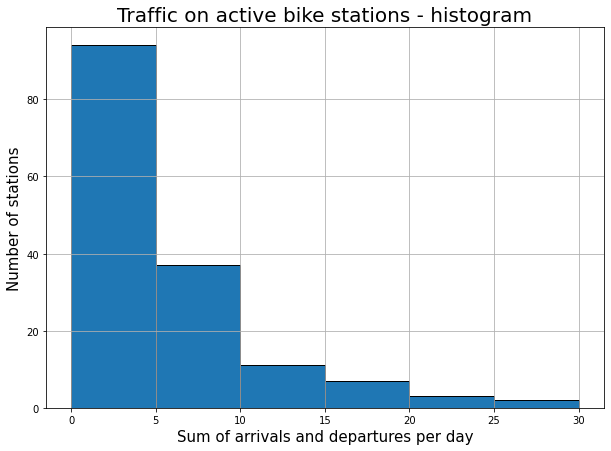

In [10]:
# Active stations - histogram
fig, ax = plt.subplots(figsize=(10,7))
activity_filtered_df = activity_df.query('arrivals >= 1/7 and departures >= 1/7')
activity_filtered_df.total.plot.hist(ax=ax, edgecolor='black', bins=list(range(0,33,5)))

ax.set_title('Traffic on active bike stations - histogram', fontsize=20)
ax.set_xlabel('Sum of arrivals and departures per day', fontsize=15)
ax.set_ylabel('Number of stations', fontsize=15)
ax.grid()
plt.show()

## Kde se kola hromadí a kde chybí

- z tabulky odjezdů a příjezdů pro jednotlivé stanice (aktivita) byl vypočítán jejich rozdíl jako přírůstky a úbytky kol
- rozdíly za celé sledované období byly přepočítány na den

**Výsledky:**
- čísla stanic s přírůstky a úbytky jsou zobrazeny graficky (pouze stanice, kde je rozdíl alespoň jedno kolo za den)

In [11]:
# differences
activity_df_diff = (activity_df
    .assign(diff_per_day = round((activity_df.arrivals - activity_df.departures), 1)))

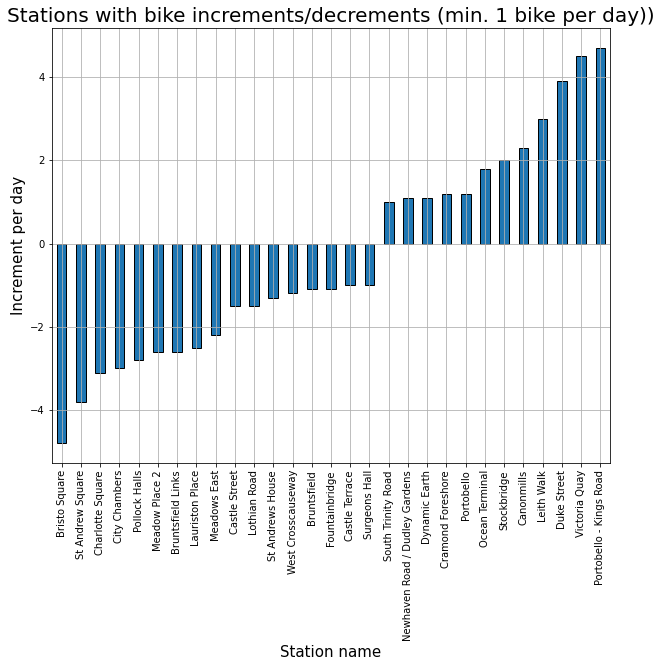

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

(activity_df_diff.query('diff_per_day <= -1 or diff_per_day >= 1')[['diff_per_day']]
 .sort_values('diff_per_day').plot.bar(ax=ax, edgecolor='black'))
ax.set_title('Stations with bike increments/decrements (min. 1 bike per day))', fontsize=20)
ax.set_xlabel('Station name', fontsize=15)
ax.set_ylabel('Increment per day', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

## Vzdálenosti mezi stanicemi

- ze všech záznamů o jízdách byly vytaženy souřadnice odjezdových a příjezdových stanic
- duplicitní záznamy souřadnic byly zprůměrovány (jednotlivé záznamy se lišily na 3.-4. desetinném místě)
- stanice č. 280 byla vyřazena, neboť je vzdálena od ostatních téměř 300 km

**Výsledky:**
- ze souřadnic byla sestavena mapa rozmístění stanic (po kliknutí na stanici se zobrazí její název a číslo)
- ze souřadnic byla vypočítána vzdálenost mezi stanicemi (tabulka 199x199 záznamů) - výřez tabulky je uveden níže

In [13]:
# select relevant data
sdf = ddf.iloc[:, [3, 6, 7, 8, 11, 12]]

In [14]:
# get coordinates from all records
df1 = (sdf
       .iloc[:, 0:3]
       .rename(columns={'start_station_id': 'ID', 'start_station_latitude': 'latitude',
                        'start_station_longitude': 'longitude'})
       .set_index('ID'))
df2 = (sdf.iloc[:, 3:]
       .rename(columns={'end_station_id': 'ID', 'end_station_latitude': 'latitude',
                        'end_station_longitude': 'longitude'})
       .set_index('ID'))

coord_df = df1.append(df2).drop_duplicates()

In [15]:
# duplicate coords - max. difference
duplicites_mask = coord_df.index.duplicated()
dupl_ids = coord_df.index[duplicites_mask]
print('Max. difference:')
display(coord_df.loc[dupl_ids].sort_index().groupby('ID').diff().dropna().max())

Max. difference:


latitude     0.000942
longitude    0.003452
dtype: float64

In [16]:
# calculate average coordinates from duplicates
coord_df = coord_df.groupby('ID').mean()

# drop outlier, join station names
coord_df = coord_df.drop(280).join(stations_df)

In [17]:
# distance calculation
def dist(id1, id2):
    '''
    Return distance in km between two station IDs from table coord_df
    ''' 
    if id1 == id2:
        return 0
    
    R = 6371  # Earth radius in km
    lat1 = coord_df.loc[id1, 'latitude']
    lon1 = coord_df.loc[id1, 'longitude']
    lat2 = coord_df.loc[id2, 'latitude']
    lon2 = coord_df.loc[id2, 'longitude']
    
    d = R*arccos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon2-lon1))*(2*np.pi/360)
    return round(d, 2)

### Interaktivní mapa stanic

In [18]:
fig = Figure(width=625, height=400)
m = folium.Map([55.95, -3.22], zoom_start=11, min_zoom=11)
fig.add_child(m)    

for i in coord_df.itertuples():
    folium.CircleMarker(
        [i[1], i[2]],
        radius=2,
        popup=folium.Popup(f'{i[3]} <br> <b>ID:</b> {i[0]}')
    ).add_to(m)
m

In [19]:
# distance table in km
ID_lst = list(coord_df.index)
distance_df = coord_df[[]]
while ID_lst:
    col_index = ID_lst.pop()
    col = pd.DataFrame(dist(col_index, ID_lst), columns=[col_index])
    distance_df = distance_df.join(col)
distance_df = distance_df.sort_index(axis=1)

### Tabulka vzdáleností (výřez)
- číslo stanice, vzdálenost v km 

In [20]:
distance_df.iloc[:11, :11].fillna('--')

,171,183,189,225,241,242,246,247,248,249,250
ID,,,,,,,,,,,
171,--,1.0,0.8,1.03,4.43,4.43,1.39,2.01,0.32,1.91,4.06
183,--,--,0.22,0.69,4.04,4.04,2.15,1.42,0.69,1.86,3.31
189,--,--,--,0.59,4.03,4.04,1.94,1.57,0.48,1.9,3.41
225,--,--,--,--,3.49,3.49,1.7,2.11,0.78,2.48,3.03
241,--,--,--,--,--,0.0,4.07,5.25,4.24,5.89,1.81
242,--,--,--,--,--,--,4.07,5.25,4.24,5.9,1.81
246,--,--,--,--,--,--,--,3.38,1.57,3.26,4.3
247,--,--,--,--,--,--,--,--,1.82,1.02,4.16
248,--,--,--,--,--,--,--,--,--,1.89,3.78


## Vývoj poptávky po kolech v čase
- pro každý den byl sečten počet odjezdů, totéž pro každý den v týdnu (po-ne)
- byl sestrojen graf časového průběhu počtu odjezdů
- byl sestrojen graf počtu odjezdů pro jednotlivé dny v týdnu

**Výsledky:**
- poptávka je závislá na sezóně (vliv ročních období)
- v roce 2020 došlo k nárůstu poptávky - možný vliv koronaviru (averze k hromadné dopravě)
- o víkendu je vyšší zájem o kola oproti pracovním dnům
- nárůst poptávky je patrný již v pátek

In [21]:
# number of departures for each day
dep_daily_df = ddf[['started_at']].groupby(ddf['started_at'].dt.date).count()
dep_daily_df.index.name = 'date'
dep_daily_df.index = pd.to_datetime(dep_daily_df.index, format='%Y-%m-%d')
dep_daily_df.rename(columns={'started_at': 'departures'}, inplace=True)
dep_daily_df = dep_daily_df.sort_index()

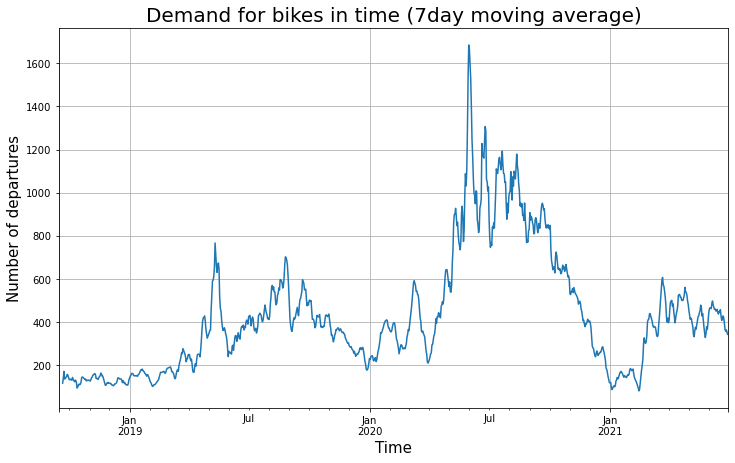

In [22]:
# rolling 7-day mean
fig, ax = plt.subplots(figsize=(12,7))
dep_daily_df.rolling(7).mean().plot(ax=ax)
 
ax.set_title('Demand for bikes in time (7day moving average)', fontsize=20)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Number of departures', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

In [23]:
# number of departures for each weekday
dep_weekday_df = dep_daily_df.groupby(dep_daily_df.index.day_name()).sum()
dep_weekday_df.index.name = 'weekday'
dep_weekday_df = (dep_weekday_df
.reindex(['Monday', 'Tuesday', 'Wednesday', 'Friday', 'Saturday', 'Sunday']))

### Mezidenní procentní nárůst výpůjček - dny v týdnu

In [24]:
# pct increase of demand between days
round(dep_weekday_df.pct_change()*100, 1).T

weekday,Monday,Tuesday,Wednesday,Friday,Saturday,Sunday
departures,NaN,1.2,1.6,6.3,11.9,-5.4


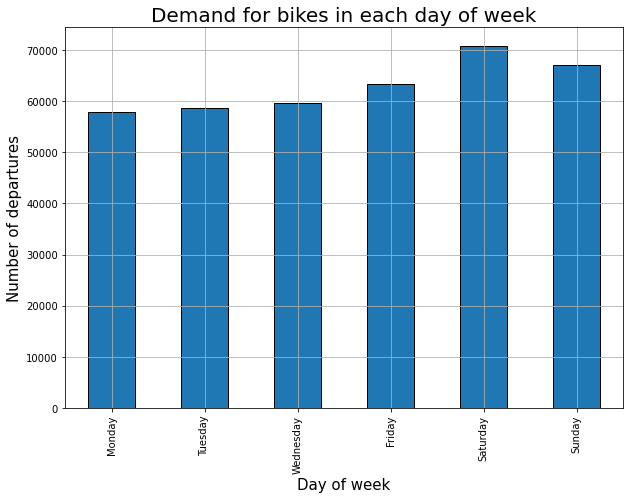

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
dep_weekday_df.plot.bar(ax=ax, edgecolor='black')
 
ax.set_title('Demand for bikes in each day of week', fontsize=20)
ax.set_xlabel('Day of week', fontsize=15)
ax.set_ylabel('Number of departures', fontsize=15)
ax.legend().remove()
ax.grid()
plt.show()

## Vliv počasí na poptávku
- z naměřených dat o počasí v Edinburgu byla vybrána teplota vzduchu a srážky
- data o počasí byla k dispozici ve dnech 15.9.2018 - 31.10.2020
- denní teplota vzduchu ve °C je brána jako aritmetický průměr měření v čase 6:00-21:00
- jelikož v roce 2020 došlo k meziročnímu nárůstu poptávky po kolech obecně, je vliv teploty porovnáván pro rok 2019 a 2020 samostatně. Pro zbylé roky nejsou k dispozici celoroční data, a byly proto vynechány. Pro rok 2020 jsou data do 31.10. 
- denní srážky jsou celkové srážky v mm v čase 6:00-21:00

**Výsledky:**
- poptávku ovlivňují mezní hodnoty teploty vzduchu (okolí bodu mrazu a 20 °C)
- v deštivých dnech výrazně klesá počet vyjížděk

In [26]:
# Data preparation
weather_df = pd.read_csv('edinburgh_weather.csv')

weather_df['datetime'] = (
    pd.to_datetime(weather_df['date'] + ' ' + weather_df['time'],
                   format='%Y-%m-%d %H:%M'))
weather_df['temp'] = (
    weather_df['temp'].apply(lambda x: x.removesuffix(' °c')).astype(int))
weather_df['rain'] = (
    weather_df['rain'].apply(lambda x: x.removesuffix(' mm')).astype(float))

weather_df = (
    weather_df.set_index('datetime')
              .drop(['Unnamed: 0', 'date', 'time', 'feels'], axis=1)
              .rename(columns={'temp': 'temp_C', 'rain': 'rain_mm'}))

In [27]:
# Temperature as daily average between 6:00 and 21:00
# Rain as sum between 6:00 and 21:00
c1 = weather_df.index.hour >= 6
c2 = weather_df.index.hour <= 21

temp_rain_df = weather_df[c1 & c2][['temp_C', 'rain_mm']]
temp_rain_df.index = pd.to_datetime(temp_rain_df.index.date, format='%Y-%m-%d')
temp_rain_df.index.name = 'date'
temp_rain_df = temp_rain_df.groupby('date').agg({'temp_C': 'mean', 'rain_mm': 'sum'})
temp_rain_df[['temp_C']] = (
    temp_rain_df[['temp_C']].apply(lambda x: x.round(0).astype(int)))

In [28]:
# Number of daily departures vs weather
dep_temp_rain_df = dep_daily_df.join(temp_rain_df).dropna()

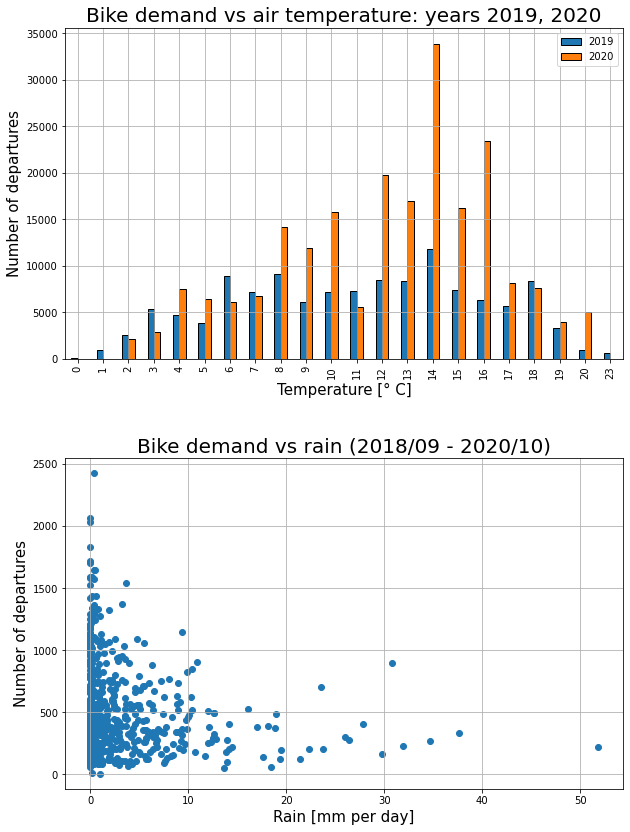

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10,14))
ax1, ax2 = axs
plt.subplots_adjust(hspace=0.3)

# temp year 2019
y19_df = (dep_temp_rain_df
          .query('date >= "2019-01-01" and date < "2020-01-01"')
          .groupby('temp_C').sum()[['departures']])
# temp year 2020
y20_df = (dep_temp_rain_df
          .query('date >= "2020-01-01" and date < "2021-01-01"')
          .groupby('temp_C').sum()[['departures']])
# both years (boxplot need the same no of rows)
y19_y20_df = y19_df.join(y20_df, lsuffix=2019, rsuffix=2020).fillna(0)
y19_y20_df = y19_y20_df.reindex(index=y19_y20_df.index.astype(int))

y19_y20_df.plot.bar(
    y = ['departures2019', 'departures2020'],
    label = ['2019', '2020'],
    ax=ax1,
    edgecolor='black')
ax1.set_title('Bike demand vs air temperature: years 2019, 2020', fontsize=20)
ax1.set_xlabel('Temperature [° C]', fontsize=15)
ax1.legend()

# rain
ax2.scatter(dep_temp_rain_df['rain_mm'], dep_temp_rain_df['departures'])
ax2.set_title('Bike demand vs rain (2018/09 - 2020/10)', fontsize=20)
ax2.set_xlabel('Rain [mm per day]', fontsize=15)

for i in [ax1, ax2]:
    i.set_ylabel('Number of departures', fontsize=15)
    i.grid()

plt.show()